In [30]:
# Import necessary libraries, install them if you do not have them
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime
from datetime import datetime
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
import cartopy.crs as ccrs



## Import and look at dataset

In [13]:
# ******* THIS IS WHEN RUNNING FROM ATLANTIS.SCI **************
# path containing our idx files
idx_dir = "/usr/sci/scratch_nvme/arleth/idx/firesmoke"
firesmoke_dir = "/usr/sci/cedmav/data/firesmoke"

In [14]:
# # ******* THIS IS WHEN RUNNING FROM MY MACBOOK **************
# # path containing our idx files
# idx_dir = "/Users/arleth/Mount/idx/firesmoke"
# firesmoke_dir = "/Users/arleth/Mount/firesmoke"

In [15]:
# open the netcdf file
# obtained here: https://firesmoke.ca/forecasts/BSC00CA12-01/2023071508/dispersion.nc
# visualized here: https://firesmoke.ca/forecasts/BSC00CA12-01/2023071508/
ds = xr.open_dataset(firesmoke_dir + "/BSC00CA12-01/dispersion_20210304.nc")

In [16]:
#view the data
var = np.squeeze(ds["PM25"].values)
print(np.shape(var))
print(np.min(var[15]),np.max(var[15]))

(51, 381, 1041)
0.0 2127.124


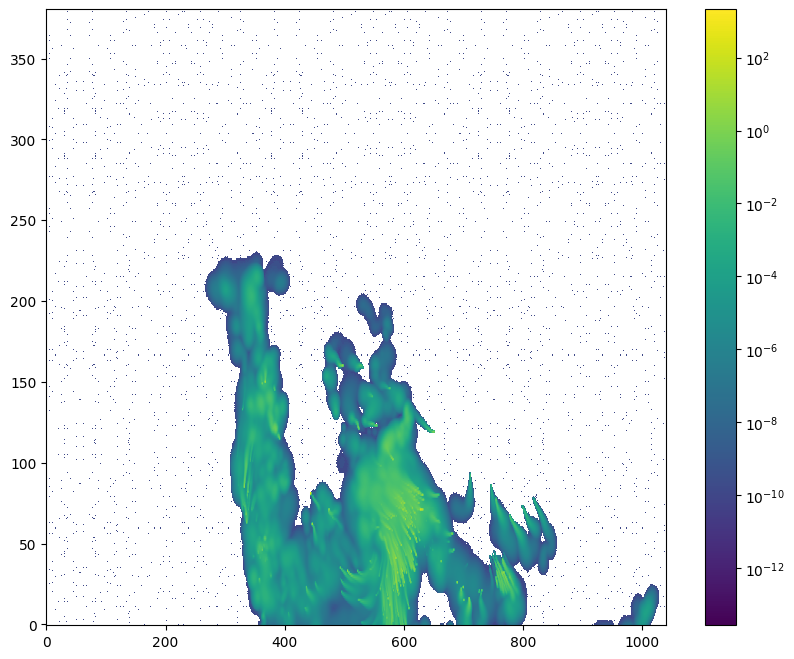

In [17]:
timestep = 15  #between 0 and 89
data = var[timestep,:,:]
fig,axes=plt.subplots(1,1,figsize=(10,8))
axp = axes.imshow(data, aspect='auto',origin='lower',cmap='viridis', norm="log")
plt.colorbar(axp,location='right')
plt.show()

## Compute longitude and latitude, get data using metadata

In [18]:
# Get metadata to compute lon and lat (credit: Aashish Panta)
xorig = ds.XORIG
yorig = ds.YORIG
xcell = ds.XCELL
ycell = ds.YCELL
ncols = ds.NCOLS
nrows = ds.NROWS

longitude = np.linspace(xorig, xorig + xcell * (ncols - 1), ncols)
latitude = np.linspace(yorig, yorig + ycell * (nrows - 1), nrows)

In [19]:
print(f'xorig = {xorig}, xcell = {xcell}')
print(f'yorig = {yorig}, ycell = {ycell}')

xorig = -156.0, xcell = 0.10000000149011612
yorig = 32.0, ycell = 0.10000000149011612


In [20]:
print(np.size(latitude), np.size(longitude))

381 1041


In [21]:
# Get timestamps from metadata (credit: Aashish Panta)
def parse_tflag(tflag):
    year = int(tflag[0] // 1000)
    day_of_year = int(tflag[0] % 1000)
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year - 1)

    time_in_day = int(tflag[1])
    hours = time_in_day // 10000
    minutes = (time_in_day % 10000) // 100
    seconds = time_in_day % 100

    full_datetime = datetime.datetime(year, date.month, date.day, hours, minutes, seconds)
    return full_datetime

def get_timestamps():
    tflag_values = ds.TFLAG.values
    timestamps = [parse_tflag(tflag[0]) for tflag in tflag_values]
    timestamps_str = [timestamp.strftime("%Y-%m-%d %H:%M:%S") for timestamp in timestamps]
    return timestamps_str
timestamps=get_timestamps()

In [22]:
np.size(timestamps)

51

In [23]:
timestamps[0]

'2021-03-04 09:00:00'

In [24]:
# Create coordinates for lon and lat (credit: Aashish Panta)
ds.coords['lon'] = ('COL', longitude)
ds.coords['lat'] = ('ROW', latitude)

In [25]:
# Replace col and row dimensions with newly calculated lon and lat arrays (credit: Aashish Panta)
ds = ds.swap_dims({'COL': 'lon', 'ROW': 'lat'})

In [26]:
# Create coordinates for time
ds.coords['time'] = ('TSTEP', timestamps)

In [27]:
# Replace tstep dimension with newly calculated timestamps array
ds = ds.swap_dims({'TSTEP': 'time'})

In [28]:
np.shape(data)

(381, 1041)

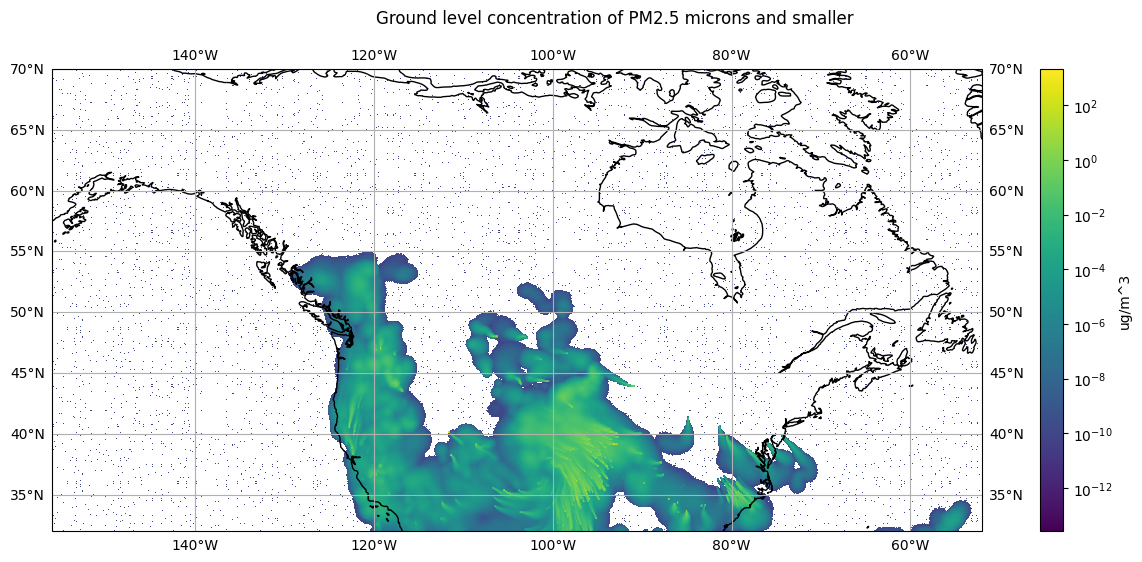

In [31]:
# Let's use matplotlib's imshow, since our data is on a grid
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

# Initialize a figure and plot, so we can customize figure and plot of data
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
# ref: https://scitools.org.uk/cartopy/docs/latest/getting_started/index.html
my_fig, my_plt = plt.subplots(figsize=(15, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Let's set some parameters to get the visualization we want
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

# color PM25 values on a log scale, since values are small
my_norm = "log" 
# this will number our x and y axes based on the longitude latitude range
my_extent = [np.min(longitude), np.max(longitude), np.min(latitude), np.max(latitude)]
# ensure the aspect ratio of our plot fits all data, matplotlib can does this automatically
my_aspect = 'auto'
# tell matplotlib, our origin is the lower-left corner
my_origin = 'lower'
# select a colormap for our plot and the color bar on the right
my_cmap = 'viridis'

# create our plot using imshow
plot = my_plt.imshow(data, norm=my_norm, extent=my_extent, 
          aspect=my_aspect, origin=my_origin, cmap=my_cmap)

# draw coastlines
my_plt.coastlines()

# draw latitude longitude lines
# ref: https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html
my_plt.gridlines(draw_labels=True)

# add a colorbar to our figure, based on the plot we just made above
my_fig.colorbar(plot,location='right', label='ug/m^3')

# # Set x and y axis labels on our ax
# my_plt.set_xlabel('Longitude')
# my_plt.set_ylabel('Latitude')

# Set title of our figure
my_fig.suptitle('Ground level concentration of PM2.5 microns and smaller')

# # Set title of our plot as the timestamp of our data
# my_plt.set_title(f'{my_timestamp}')

# Show the resulting visualization
plt.show()

Extract timesteps 15-(15+23), which is 1 full day

In [ ]:
print(timestamps[15], timestamps[15+23])

In [ ]:
# determine the maximum pm25 value, to normalize data for visualization
# unfortunately, necessary bc np.max() does not handle nan values
max_pm25 = 0
for i in range(np.size(ds.time)):
    # get pm25 data that is > than 1
    pm25_data = ds['PM25'][i,:,:].where(ds['PM25'][i,:,:].values > 1)
    # get the values from DataArray
    pm25_data = pm25_data.values.flatten()
    # strip nan values
    # ref: https://stackoverflow.com/questions/11620914/how-do-i-remove-nan-values-from-a-numpy-array
    pm25_data = pm25_data[~np.isnan(pm25_data)]
    if np.size(pm25_data):
        max_pm25 = np.max([max_pm25, np.max(pm25_data)])

# scale down the max pm25 value to normalize all data points
scalar = max_pm25
print("Max pm25 value in entire dataset is: ", max_pm25)
print("'scalar' is:", scalar)

In [ ]:
for i in np.arange(15, 15+24):
    print(i, timestamps[i])

In [ ]:
np.shape(timestamps)

In [ ]:
# # Get the PM25 values, squeeze out empty axis
# file_vals = ((ds['PM25'].values))

# # Get h'th hour of data, a 2D slice
# tstep_hour_vals = file_vals[h]
# print(np.shape(file_vals), np.shape(tstep_hour_vals))

In [ ]:
file_vals = np.squeeze(ds['PM25'].values)
np.shape(file_vals)

In [ ]:
for h in np.arange(15, 15+24):
    # Get the PM25 values, squeeze out empty axis
    file_vals = (np.squeeze(ds['PM25'].values))
    
    # Get 1 hour of data
    tstep_hour_vals = file_vals[h]

    print(np.shape(tstep_hour_vals))

In [ ]:
# Create grid to map PM25 values to lat long coords for each time step (credit: Aashish Panta)
def map_heat_time_data(data):
    # Array to populate
    heat_time_data = []
    # For each timestep
    for i in range(np.size(ds.time)):
        #**************FIX THIS*********************
        # get pm25 data that is not nan (?)
        # pm25_data = np.squeeze(ds['PM25'][i,:,:])
        pm25_data = np.squeeze(ds['PM25'][i,:,:]).where(ds['PM25'][i,:,:].values > 1))
        # print(np.shape(pm25_data))
        # get the values from DataArray
        pm25_data = pm25_data.values
        # print(np.shape(pm25_data))
        # create iterator of data over latitude and longitude values on current timestep i
        heat_data_i = [
            [lat, lon, float(var)]
            for lat, lon, var in zip(
                np.repeat(latitude, ncols),
                np.tile(longitude, nrows),
                pm25_data.flatten()
            )
            if var > 0
        ]
        # append to final array
        heat_time_data.append(heat_data_i)
    return heat_time_data

## Normalize PM25 values to be between 0 and 1 (for visualization weights)

In [ ]:
# note, heat_time_data is a list of different sized numpy arrays
heat_time_data = map_heat_time_data(ds)

In [ ]:
np.shape(heat_time_data[0])

In [ ]:
# create color map
# used this: https://colorbrewer2.org/#type=diverging&scheme=BrBG&n=3
cmap = {
    0: '#ffffb2',
    0.2: '#fed976',
    0.4: '#feb24c',
    0.6: '#fd8d3c',
    0.8: '#f03b20',
    1: '#420300'
}

list(cmap.values())

In [ ]:
# Initialize map to Calgary's lat and lon (as in firesmoke.ca)
m = folium.Map([51, -106], zoom_start=6)
m_t = folium.Map([51, -106], zoom_start=6)

In [ ]:
# # add heat data to heatmap for time step 0
HeatMap(heat_time_data[0]).add_to(m)
# add heat time data to heatmap
# hm = folium.plugins.HeatMapWithTime(heat_time_data)
hm = folium.plugins.HeatMapWithTime(heat_time_data, timestamps, radius=0.4, blur=0.6,
                                    gradient=cmap, min_opacity=0.5, max_opacity=1, scale_radius=True)
hm.add_to(m_t)


In [ ]:
# add legend for color map
cmap_bar = cm.StepColormap(list(cmap.values()), vmin=1, vmax=250)
cmap_bar.caption ="PM_2.5"
cmap_bar
m_t.add_child(cmap_bar)
m_t

In [ ]:
# item_txt = """<br> &nbsp; {item} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{col}"></i>"""
# html_itms = item_txt.format( item= "mark_1" , col= "red")
# legend_html = """
#      <div style="
#      position: fixed; 
#      bottom: 50px; left: 50px; width: 200px; height: 160px; 
#      border:2px solid grey; z-index:9999; 
     
#      background-color:white;
#      opacity: .85;
     
#      font-size:14px;
#      font-weight: bold;
     
#      ">
#      &nbsp; {title} 
     
#      {itm_txt}

#       </div> """.format( title = "Legend html", itm_txt= html_itms)
# m_t.get_root().html.add_child(folium.Element( legend_html ))

m_t

Save the visualization to an HTML file. It runs stand alone.
To improve the visualization by adding a better legend, information tool bar, javascript/html/css development will be necessary (if using folium anyway).

In [ ]:
# # save the map as an html file
# m_t.save("index.html")